In [159]:
import numpy as np
import pandas as pd
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import bz2
import random
from datetime import datetime, timedelta
from dateutil.relativedelta import relativedelta
from scipy.stats import rankdata  


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 206296 entries, 0 to 206295
Data columns (total 33 columns):
 #   Column              Non-Null Count   Dtype         
---  ------              --------------   -----         
 0   tournamentId        206296 non-null  int32         
 1   tournament_name     206296 non-null  object        
 2   type                206296 non-null  object        
 3   division            206296 non-null  object        
 4   divisionId          206296 non-null  object        
 5   gender              206296 non-null  object        
 6   age_type            206296 non-null  object        
 7   match_id            206296 non-null  int32         
 8   roundNumber         206296 non-null  int32         
 9   matchNumber         206296 non-null  int32         
 10  matchWinner         206296 non-null  object        
 11  series_number       206296 non-null  int32         
 12  match_type          206296 non-null  object        
 13  isMatch             206296 no

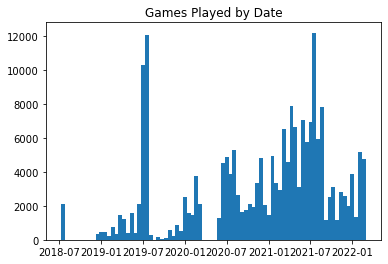

In [160]:


#Pickle in vball data
with open('/Users/cameron/Documents/SMU_DS/Capstone/SMU_Capstone_Project/Pickle_Files/vball_game_data.pbz2', 'rb') as file:
    uncompressed = bz2.BZ2File(file)
    vball = pickle.load(uncompressed)

#Move to data frame
df_vball=pd.DataFrame(vball)

df_vball.info()
df_vball.head()

#Look at game density over time before time filtering
plt.hist(df_vball[['datetime']],bins=80)
plt.title('Games Played by Date')
plt.show()


In [163]:
def network_model(dataset,train_start_date,training_period_days,prediction_period_days,rw_iterations,reset_probability,train_end_date=None):
  pred_date_check=False
  result_holder=[]
  loop=1
  pred_count=0
  while pred_date_check==False:
    if loop==1:
      reference_date=train_start_date
    if loop>1:
      reference_date=pred_end_date-timedelta(days=training_period_days)
    
    loop+=1
    #filter for train_start_date
    ref_end_date=reference_date+timedelta(days=training_period_days)
    df_recent=dataset.loc[(dataset['datetime'] >= reference_date) & (dataset['datetime'] < ref_end_date)]
    
    #Filter out games with no score
    df_recent=df_recent[(df_recent.ignored_score==False) & (df_recent.incomplete_score==False)]
    df_recent=df_recent.reset_index()

    #Get all opponents in one column for group by
    df_recent_dup=df_recent.copy()
    df_recent_dup.opponent1_id=df_recent_dup.opponent2_id

    df_long=df_recent.copy()
    df_long=df_long.append(df_recent_dup, ignore_index = True)

    # #Group players by points played against each opponent which can be used to understand confidence of rating
    # grp_pts_played=df_long.groupby(['player_id','opponent1_id'])["winning_score"].sum()

    #Group players by pct points won average which can be used to understand who is better
    grp_pct_pts_won=df_long.groupby(['player_id','opponent1_id'])["pct_points_won"].mean()

    #Create unique player list and set up empty matrices
    player_list=sorted(list(df_recent['player_id'].unique()))
    # points_matrix=np.zeros((len(player_list),len(player_list)))
    pct_points_matrix=np.zeros((len(player_list),len(player_list)))

    #Create dictionary of sum of points played and avg pct points won
    # dict_pts_played=dict(grp_pts_played)
    dict_pct_pts_won=dict(grp_pct_pts_won)
    player_order_dict={k:v for v,k in enumerate(player_list)}

    # #Fill points matrix (from row to column id)
    # for k,v in dict_pts_played.items():
    #   points_matrix[player_order_dict[k[0]],player_order_dict[k[1]]]=v

    #Fill pct points won matrix (from row to column id)
    #Using 1-v so that the edges point to the better team
    for k,v in dict_pct_pts_won.items():
      pct_points_matrix[player_order_dict[k[0]],player_order_dict[k[1]]]=1-v

    #Random Walk
    holder=[]
    restart=True
    iterations=rw_iterations
    for i in range(iterations):
      if restart==True:
        random.seed(i)
        start_row = random.randint(0,len(player_list)-1)
        holder.append(start_row)
        new_row = random.choices(list(range(len(player_list))), weights=list(pct_points_matrix[start_row,:]), k=1)
        restart=False
      else:
        new_row = random.choices(list(range(len(player_list))), weights=list(pct_points_matrix[new_row[0],:]), k=1)  
      
      holder.append(new_row[0])
      
      random.seed(i)
      random_val=random.randint(1,10000)
      if random_val<=round(reset_probability*10000,0):
        restart=True
      
      # if i%(iterations-1)==0 and i!=0:
      #   print('model trained')

    ratings={k: v for k, v in sorted(Counter(holder).items(), key=lambda item: item[1],reverse=True)}
    rankings=dict(zip(ratings.keys(), rankdata([-i for i in ratings.values()], method='average')))

    pred_start_date=ref_end_date
    pred_end_date=pred_start_date+timedelta(days=prediction_period_days)
    df_pred=df_vball.loc[(df_vball['datetime'] >= pred_start_date) & (df_vball['datetime'] < pred_end_date),['player_id','teammate_id','opponent1_id','opponent2_id']].to_numpy()
    df_target=df_vball.loc[(df_vball['datetime'] >= pred_start_date) & (df_vball['datetime'] < pred_end_date),['win']].to_numpy()
      
    df_pred=df_pred[::4]
    df_target=df_target[::4]
  
    for i,row in enumerate(df_pred):
      if any(x in rankings for x in row[[0,1]]) and any(x in rankings for x in row[[0,1]]):
          team1=(rankings.get(row[0],row[1])+rankings.get(row[1],row[0]))/2
          team2=(rankings.get(row[2],row[3])+rankings.get(row[3],row[2]))/2
          if team1==team2:
              result_holder.append(-1) #predicted tie
          elif min(team1,team2)==team1 and df_target[i]==True:
              result_holder.append(1) #correct prediction
          else:
              result_holder.append(0) #incorrect prediction
      else:
        result_holder.append(-2) #one team was completely unranked
        
        

    if train_end_date==None:
      if pred_end_date>max(dataset.datetime):
        pred_date_check=True
    else:
      if pred_end_date>train_end_date:
        pred_date_check=True
  
    pred_count+=len(df_pred)
    # print(len(df_recent))
    # print(reference_date)
    # print(ref_end_date)
    # print(len(df_pred))
    # print(pred_start_date)
    print('Model updated through',pred_end_date)
    # print(pred_count)

  print(Counter(result_holder))
  print('accuracy:',Counter(result_holder)[1]/(Counter(result_holder)[0]+Counter(result_holder)[1]))

In [153]:
#network_model(dataset,train_start_date,training_period_days,prediction_period_days,rw_iterations,reset_probability,train_end_date=None):
network_model(df_vball,datetime(2018, 12, 9),365,30,100000,.05)

model trained
model trained
model trained
model trained
model trained
model trained
model trained
model trained
model trained
model trained
model trained
model trained
model trained
model trained
model trained
model trained
model trained
model trained
model trained
model trained
model trained
model trained
model trained
model trained
model trained
model trained
model trained
model trained
Counter({1: 11843, 0: 7508, -1: 10})
accuracy: 0.6120097152601933
skipped games due to unranked team: 23031


In [157]:
#network_model(dataset,train_start_date,training_period_days,prediction_period_days,rw_iterations,reset_probability,train_end_date=None):
network_model(df_vball,datetime(2018, 12, 9),365,15,200000,.05)

Model updated through 2019-12-24 00:00:00
Model updated through 2020-01-08 00:00:00
Model updated through 2020-01-23 00:00:00
Model updated through 2020-02-07 00:00:00
Model updated through 2020-02-22 00:00:00
Model updated through 2020-03-08 00:00:00
Model updated through 2020-03-23 00:00:00
Model updated through 2020-04-07 00:00:00
Model updated through 2020-04-22 00:00:00
Model updated through 2020-05-07 00:00:00
Model updated through 2020-05-22 00:00:00
Model updated through 2020-06-06 00:00:00
Model updated through 2020-06-21 00:00:00
Model updated through 2020-07-06 00:00:00
Model updated through 2020-07-21 00:00:00
Model updated through 2020-08-05 00:00:00
Model updated through 2020-08-20 00:00:00
Model updated through 2020-09-04 00:00:00
Model updated through 2020-09-19 00:00:00
Model updated through 2020-10-04 00:00:00
Model updated through 2020-10-19 00:00:00
Model updated through 2020-11-03 00:00:00
Model updated through 2020-11-18 00:00:00
Model updated through 2020-12-03 0

In [165]:
#network_model(dataset,train_start_date,training_period_days,prediction_period_days,rw_iterations,reset_probability,train_end_date=None):
network_model(df_vball,datetime(2018, 12, 9),730,30,120000,.05)

Model updated through 2021-01-07 00:00:00
Model updated through 2021-02-06 00:00:00
Model updated through 2021-03-08 00:00:00
Model updated through 2021-04-07 00:00:00
Model updated through 2021-05-07 00:00:00
Model updated through 2021-06-06 00:00:00
Model updated through 2021-07-06 00:00:00
Model updated through 2021-08-05 00:00:00
Model updated through 2021-09-04 00:00:00
Model updated through 2021-10-04 00:00:00
Model updated through 2021-11-03 00:00:00
Model updated through 2021-12-03 00:00:00
Model updated through 2022-01-02 00:00:00
Model updated through 2022-02-01 00:00:00
Model updated through 2022-03-03 00:00:00
Counter({-2: 13587, 1: 9697, 0: 6624, -1: 7})
accuracy: 0.5941425157772195
Proportion skipped games due to unranked team: 0.0


In [166]:
#network_model(dataset,train_start_date,training_period_days,prediction_period_days,rw_iterations,reset_probability,train_end_date=None):
network_model(df_vball,datetime(2018, 12, 9),180,30,100000,.05)

Model updated through 2019-07-07 00:00:00
Model updated through 2019-08-06 00:00:00
Model updated through 2019-09-05 00:00:00
Model updated through 2019-10-05 00:00:00
Model updated through 2019-11-04 00:00:00
Model updated through 2019-12-04 00:00:00
Model updated through 2020-01-03 00:00:00
Model updated through 2020-02-02 00:00:00
Model updated through 2020-03-03 00:00:00
Model updated through 2020-04-02 00:00:00
Model updated through 2020-05-02 00:00:00
Model updated through 2020-06-01 00:00:00
Model updated through 2020-07-01 00:00:00
Model updated through 2020-07-31 00:00:00
Model updated through 2020-08-30 00:00:00
Model updated through 2020-09-29 00:00:00
Model updated through 2020-10-29 00:00:00
Model updated through 2020-11-28 00:00:00
Model updated through 2020-12-28 00:00:00
Model updated through 2021-01-27 00:00:00
Model updated through 2021-02-26 00:00:00
Model updated through 2021-03-28 00:00:00
Model updated through 2021-04-27 00:00:00
Model updated through 2021-05-27 0

In [167]:
#network_model(dataset,train_start_date,training_period_days,prediction_period_days,rw_iterations,reset_probability,train_end_date=None):
network_model(df_vball,datetime(2018, 12, 9),90,30,70000,.05)

Model updated through 2019-04-08 00:00:00
Model updated through 2019-05-08 00:00:00
Model updated through 2019-06-07 00:00:00
Model updated through 2019-07-07 00:00:00
Model updated through 2019-08-06 00:00:00
Model updated through 2019-09-05 00:00:00
Model updated through 2019-10-05 00:00:00
Model updated through 2019-11-04 00:00:00
Model updated through 2019-12-04 00:00:00
Model updated through 2020-01-03 00:00:00
Model updated through 2020-02-02 00:00:00
Model updated through 2020-03-03 00:00:00
Model updated through 2020-04-02 00:00:00
Model updated through 2020-05-02 00:00:00
Model updated through 2020-06-01 00:00:00
Model updated through 2020-07-01 00:00:00
Model updated through 2020-07-31 00:00:00
Model updated through 2020-08-30 00:00:00
Model updated through 2020-09-29 00:00:00
Model updated through 2020-10-29 00:00:00
Model updated through 2020-11-28 00:00:00
Model updated through 2020-12-28 00:00:00
Model updated through 2021-01-27 00:00:00
Model updated through 2021-02-26 0

In [136]:
#filter for first continuous year of data based on histogram
reference_date=datetime(2019, 12, 9)
df_recent=df_vball.loc[(df_vball['datetime'] >= reference_date-timedelta(days=365)) & (df_vball['datetime'] < reference_date)]
len(df_recent)/4


8654.0

In [137]:
#Review games lost due to no score (6.07%)
print('games with ignored or incomplete score:',len(df_recent[(df_recent.ignored_score==True) | (df_recent.incomplete_score==True)])/len(df_recent)) #Using the reverse of this filter

#Filter out games with no score
df_recent=df_recent[(df_recent.ignored_score==False) & (df_recent.incomplete_score==False)]
df_recent=df_recent.reset_index()
print('games used for model',len(df_recent)/4)

games with ignored or incomplete score: 0.06078114166859256
games used for model 8128.0


In [138]:

# #Do not use required score because of win by 2 rule
# df_recent.loc[df_recent.required_score!=df_recent.winning_score,['team_score','opponent_score','required_score','winning_score']]

#Get all opponents in one column for group by
df_recent_dup=df_recent.copy()
df_recent_dup.opponent1_id=df_recent_dup.opponent2_id

df_long=df_recent.copy()
df_long=df_long.append(df_recent_dup, ignore_index = True)

#Verify df_long is twice as long
len(df_recent)
len(df_long)

#Group players by points played against each opponent which can be used to understand confidence of rating
grp_pts_played=df_long.groupby(['player_id','opponent1_id'])["winning_score"].sum()

#Group players by pct points won average which can be used to understand who is better
grp_pct_pts_won=df_long.groupby(['player_id','opponent1_id'])["pct_points_won"].mean()

#Create unique player list and set up empty matrices
player_list=sorted(list(df_recent['player_id'].unique()))
# points_matrix=np.zeros((len(player_list),len(player_list)))
pct_points_matrix=np.zeros((len(player_list),len(player_list)))

#Create dictionary of sum of points played and avg pct points won
# dict_pts_played=dict(grp_pts_played)
dict_pct_pts_won=dict(grp_pct_pts_won)
player_order_dict={k:v for v,k in enumerate(player_list)}

# #Fill points matrix (from row to column id)
# for k,v in dict_pts_played.items():
#   points_matrix[player_order_dict[k[0]],player_order_dict[k[1]]]=v

#Fill pct points won matrix (from row to column id)
#Using 1-v so that the edges point to the better team
for k,v in dict_pct_pts_won.items():
  pct_points_matrix[player_order_dict[k[0]],player_order_dict[k[1]]]=1-v




In [69]:
print('unique players:',len(player_list))
print('players with at least one RW landing:',len(set(holder)))
print('restarts:',len(holder)-iterations)
print(Counter(holder).most_common(10))

unique players: 2417
players with at least one RW landing: 2417
restarts: 29748
[(174, 3263), (53, 2479), (48, 2414), (2, 2304), (146, 2284), (74, 2250), (288, 2231), (128, 2216), (215, 2183), (307, 2134)]


In [75]:
ratings={k: v for k, v in sorted(Counter(holder).items(), key=lambda item: item[1],reverse=True)}
rankings=dict(zip(ratings.keys(), rankdata([-i for i in ratings.values()], method='average')))
# [x for x in list(Counter(holder).items())]

In [88]:
pred_start_date=datetime(2019, 12, 9)
pred_end_date=pred_start_date+relativedelta(months=3)
df_pred=df_vball.loc[(df_vball['datetime'] >= pred_start_date) & (df_vball['datetime'] < pred_end_date),['player_id','teammate_id','opponent1_id','opponent2_id']].to_numpy()
df_target=df_vball.loc[(df_vball['datetime'] >= pred_start_date) & (df_vball['datetime'] < pred_end_date),['win']].to_numpy()

array([[False],
       [ True],
       [False],
       ...,
       [ True],
       [ True],
       [False]])

In [108]:
df_pred[500][[0,1]]

array([ 742, 1282], dtype=int32)

In [110]:
rankings[1282]

329.0

In [97]:
rankings

{174: 1.0,
 53: 2.0,
 48: 3.0,
 2: 4.0,
 146: 5.0,
 74: 6.0,
 288: 7.0,
 128: 8.0,
 215: 9.0,
 307: 10.0,
 51: 11.0,
 20: 12.0,
 740: 13.0,
 851: 14.0,
 281: 15.0,
 6: 16.0,
 54: 17.0,
 65: 18.0,
 84: 19.0,
 169: 20.0,
 229: 21.0,
 198: 22.0,
 1256: 23.0,
 86: 24.0,
 334: 25.0,
 289: 26.0,
 642: 27.0,
 31: 28.0,
 118: 29.0,
 115: 30.0,
 602: 31.0,
 1098: 32.0,
 234: 33.0,
 70: 34.0,
 492: 35.0,
 38: 36.0,
 758: 37.0,
 32: 38.0,
 165: 39.0,
 673: 40.0,
 10: 41.0,
 670: 42.0,
 218: 43.5,
 94: 43.5,
 643: 45.0,
 12: 46.0,
 726: 47.0,
 322: 48.0,
 7: 49.0,
 1363: 50.0,
 345: 51.0,
 104: 52.0,
 17: 53.0,
 22: 54.0,
 250: 55.0,
 504: 56.0,
 45: 57.0,
 741: 58.0,
 223: 59.0,
 648: 60.0,
 723: 61.0,
 40: 62.0,
 87: 63.5,
 573: 63.5,
 1148: 65.0,
 1404: 66.0,
 352: 67.0,
 216: 68.0,
 663: 69.0,
 1002: 70.0,
 91: 71.0,
 797: 72.0,
 543: 73.0,
 108: 74.0,
 344: 75.0,
 42: 76.0,
 3: 77.0,
 660: 78.0,
 484: 79.0,
 95: 80.0,
 83: 81.0,
 99: 82.5,
 623: 82.5,
 828: 84.0,
 801: 85.0,
 13: 86.0,
 638: 

In [120]:
df_pred=df_pred[::4]
df_target=df_target[::4]
result_holder=[]
for i,row in enumerate(df_pred):
    if any(x in rankings for x in row[[0,1]]) and any(x in rankings for x in row[[0,1]]):
        team1=(rankings.get(row[0],row[1])+rankings.get(row[1],row[0]))/2
        team2=(rankings.get(row[2],row[3])+rankings.get(row[3],row[2]))/2
        if team1==team2:
            result_holder.append(-1) #predicted tie
        elif min(team1,team2)==team1 and df_target[i]==True:
            result_holder.append(1) #correct prediction
        else:
            result_holder.append(0) #incorrect prediction  

In [129]:
print(Counter(result_holder))
print('accuracy:',Counter(result_holder)[1]/(Counter(result_holder)[0]+Counter(result_holder)[1]))
print('skipped games due to unranked team:',len(df_pred)-sum(Counter(result_holder).values()))

Counter({1: 66, 0: 46})
accuracy: 0.5892857142857143
skipped games due to unranked team: 70
